# Two Part Hurdle Model
Julian Hsu

24 Feb 2023


The purpose of this script is to demonstrate that a treatment can result in changing two related outcomes, specifically whether the outcome is 0 or positive (aka the external margin) and the positive values of the outcome (aka the internal margin). Studying only one of the internal margin into account will lead to the wrong conclusion.

Examples of this are whenever you have a funnel, such as **Ad/webpage conversion:** A user sees an ad and decides whether to click on it, and only then can decide whether to purchase. This comes up whenever there are sequential decisions that a customer has to make before the business metric (conversion, purchase order) can be measured.

We can think of this as a [Truncated normal hurdle model](https://en.wikipedia.org/wiki/Truncated_normal_hurdle_model) or a [Tobit model](https://en.wikipedia.org/wiki/Tobit_model). There is an outcome $y$ we observe only when $t=$. Taking the ad/wepage example, $y$ can be purchase order from the ad and $t$ is whether they click on the website.


$$y = y^* t $$,
where $$ y^* = \tau w + u $$, and
$$ t = 1[\gamma w + e > 0] $$
where $w$ is whether an observation is treatment vs control, and $e$ and $u$ are independently distributed values.

### Soundbyte
Use all your data to measure your experiments' multiple touch points. An experiment that changes the upstream experience of a purchase funnel can impact increasing the likelihood of moving downstream. For example, your *new home page can increase the number of customres who make it to the purchase page.* If you only look at the purchases of users who make it to the purchase page, then you are missing the non-purchases of users who never made it past the home page. Below I show that only using the downstream data (ie revenue from purchasing customers only) can overstate the true impact because you are not taking into account that your control group is less likely to make it to the purchase page.


In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [2]:
def hurdle_data(N=1000, tau=1, gamma=1):
    ## Generate input data and error
    ## Also input a covariate feature to allow additional variation
    output_df = pd.DataFrame(
        data= {'x':np.random.normal(0,1,N),
               'e': np.random.normal(0,1,N),
          'u':np.random.normal(0,1,N),
          'w':np.random.choice(2,N).astype(float)}
        )
    ## Generate the external margin
    output_df['t'] = (gamma*output_df['w'] + output_df['e'] + 0.5*output_df['x']) > 0
    ## Generate the internal margin 
    output_df['y_star'] = 3+tau * output_df['w'] + 0.5*output_df['x'] + output_df['u']
    ## Generate observed outcome
    output_df['y'] = output_df['y_star']*output_df['t']
    return output_df

In [3]:
external_effect = 1
internal_effect = 1
df = hurdle_data(N=1000, tau=external_effect, gamma=internal_effect)

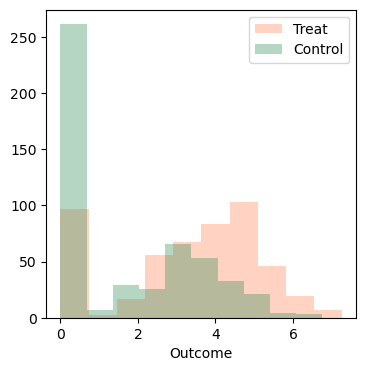

In [4]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4))
ax.hist(df.loc[df['w']==1]['y'], alpha=0.35, color='coral', label='Treat')
ax.hist(df.loc[df['w']==0]['y'], alpha=0.35, color='seagreen', label='Control')
ax.legend()
ax.set_xlabel('Outcome')
plt.show()


What happens if you just focus on the non-zero outcomes? Here we can just do a t-test since we do not have any confounding.
We will see that we cannot consistently recover the true impact.

Note that this simple approach is valid for whether `y` is not zero or not (measured by the probability `t==1`), since we do not need to take into account any upstream processes.

In [5]:
def internal_only():
    treat_naive = df.loc[(df['w']==1) & (df['t']==1)]['y'].mean()
    cntrl_naive = df.loc[(df['w']==0) & (df['t']==1)]['y'].mean()
    return treat_naive - cntrl_naive
def external_only():
    treat_naive = df.loc[(df['w']==1)]['t'].mean()
    cntrl_naive = df.loc[(df['w']==0)]['t'].mean()
    return treat_naive - cntrl_naive
def agg_comparison():
    treat_all = df.loc[df['w']==1]['y'].mean()
    cntrl_all = df.loc[df['w']==0]['y'].mean()
    return treat_all - cntrl_all
print('Estimated difference only looking at internal margin is {0:5.2f}, the external margin is {1:5.2f}, all the data is {2:5.2f}, and the truth value is {3:5.2f}'.format(internal_only(), external_only(), agg_comparison(), internal_effect))


Estimated difference only looking at internal margin is  0.80, the external margin is  0.32, all the data is  1.68, and the truth value is  1.00


Let's treat this as a regression problem, where we control for x. Go for a simple approach with OLS.

This will give us the impact of the treatment `w` taking into account the change of whether `y` is zero or not, and the increase in `y` conditional on that.

In [6]:
X = sm.add_constant(df[['x','w']])
ols_r = sm.OLS(df['y'],X).fit()
print('Estimate from OLS is {0:5.2f} with a standard error of {1:5.2f}'.format(ols_r.params['w'], ols_r.bse['w']))
print('The true impact on the internal margin of y is {0:5.2f}'.format(internal_effect))
# display(  ols_r.summary()  )

Estimate from OLS is  1.60 with a standard error of  0.10
The true impact on the internal margin of y is  1.00


What this means is that only looking at the internal margin will not give you the whole story. You need to look at the entire dataset to know the real lift. Let's demonstrate this by trying different external margin effects, and holding the internal margin effect the same. 

We want to know how the bias of only looking at the internal margin changes at the external margin effect (which we ignore) changes.

In [7]:
true_internal_impact = 0.50
df_sim = pd.DataFrame()
for e_ in np.arange(-10.1,20,1.20):
    df = hurdle_data(N=1000, tau=e_, gamma=true_internal_impact)
    agg_estimate = agg_comparison()
    internal_estimate = internal_only()
    df_sim = pd.concat([df_sim, pd.DataFrame(index=[0],data={'external_effect':e_, 
                                                             'internal_estimate':internal_estimate, 
                                                             'true_internal': true_internal_impact,  
                                                             'agg_estimate':agg_estimate})])

In [8]:
df_sim['external_internal_ratio'] = df_sim['external_effect'] / df_sim['true_internal']

In [9]:
# df_sim.rename(columns={'internal_estimate':'Estimate only when Y is not zero',
#                       'external_internal_ratio':'External:Internal Effect'}).plot(x='External:Internal Effect',
#             y=['Estimate only when Y is not zero'],
#             ylabel='Estimate on the Outcome',
#             marker='o',
#             grid=True,
#             figsize=(5,2),
#            xlabel='External:Internal Effect')

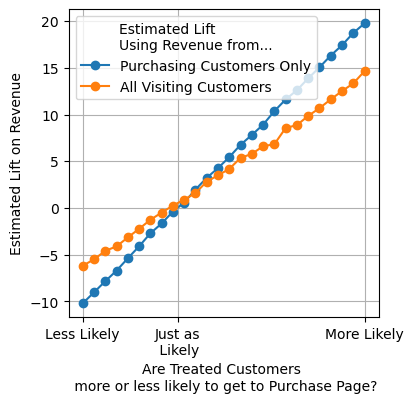

In [34]:
y1title='Purchasing Customers Only'
y2title='All Visiting Customers'
ax = df_sim.rename(columns={'internal_estimate':y1title,
                      'agg_estimate':y2title}).plot(x='external_effect',
            y=[y1title,y2title],
            ylabel='Estimated Lift on Revenue',                                                                                      
            marker='o',
            grid=True,
            figsize=(4,4),
           xlabel="Are Treated Customers \n more or less likely to get to Purchase Page?",
            xticks=[df_sim['external_effect'].min(), 0, df_sim['external_effect'].max()])
ax.set_xticklabels(['Less Likely','Just as\n Likely','More Likely'])
ax.legend(title='Estimated Lift \nUsing Revenue from...')

In [11]:
## more likely to make it to the end and have y >0, so treatment will just have more bigger y because more likely to make it there and control has more zeros.